# Point cloud classification using PointCNN 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Point-cloud-classification-using-PointCNN" data-toc-modified-id="Point-cloud-classification-using-PointCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Point cloud classification using PointCNN</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Point-cloud-classification" data-toc-modified-id="Point-cloud-classification-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Point cloud classification</a></span></li><li><span><a href="#X-Conv-operation" data-toc-modified-id="X-Conv-operation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>X-Conv operation</a></span></li><li><span><a href="#PointCNN-classification-architecture" data-toc-modified-id="PointCNN-classification-architecture-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>PointCNN classification architecture</a></span></li><li><span><a href="#Implementation-in-arcgis.learn" data-toc-modified-id="Implementation-in-arcgis.learn-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Implementation in <code>arcgis.learn</code></a></span><ul class="toc-item"><li><span><a href="#For-advanced-users" data-toc-modified-id="For-advanced-users-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>For advanced users</a></span></li></ul></li><li><span><a href="#Setting-up-the-environment" data-toc-modified-id="Setting-up-the-environment-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Setting up the environment</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#For-ArcGIS-Pro-users:" data-toc-modified-id="For-ArcGIS-Pro-users:-1.6.0.1"><span class="toc-item-num">1.6.0.1&nbsp;&nbsp;</span>For ArcGIS Pro users:</a></span></li><li><span><a href="#For-Anaconda-users-(Windows-and-Linux-platforms):" data-toc-modified-id="For-Anaconda-users-(Windows-and-Linux-platforms):-1.6.0.2"><span class="toc-item-num">1.6.0.2&nbsp;&nbsp;</span>For Anaconda users (Windows and Linux platforms):</a></span></li></ul></li></ul></li><li><span><a href="#Best-practices-for-PointCNN-workflow" data-toc-modified-id="Best-practices-for-PointCNN-workflow-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Best practices for PointCNN workflow</a></span></li><li><span><a href="#References" data-toc-modified-id="References-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>References</a></span></li></ul></li></ul></div>

## Introduction

The `arcgis.learn` module includes PointCNN  <a href="#References">[1]</a>, to efficiently classify points from a point cloud dataset. Point cloud datasets are typically collected using LiDAR sensors (light detection and ranging) – an optical remote-sensing technique that uses laser light to densely sample the surface of the earth, producing highly accurate x, y, and z measurements. These measurements of points, once post-processed and spatially organized are referred to as a 'Point cloud' and are typically collected using terrestrial (both mobile or static) and airborne LiDAR.

Point clouds are large collections of 3D elevation points, which include x, y, and z, along with additional attributes such as, but not limited to: 'GPS timestamps', 'intensity' - the return strength of the laser pulse that generated the LiDAR point, and 'number of returns' - the total number of returns for a given pulse. Additionally, with further post-processing, the LiDAR data can be further attributed with RGB (red, green, and blue) bands - often derived from imagery collected at the same time as the LiDAR survey, as well as point classification - where each point gets assigned a classification (class code) that defines the type of object that has reflected the laser pulse. LiDAR points can be classified into several categories including elevations for the ground, buildings, forest canopy, highway overpasses, water, and anything else that the laser beam encounters during the survey. The different classes are defined using numeric integer codes. Point cloud data is typically stored in the industry-standard file format - LAS.

It is in this aspect of point cloud classification where deep learning and neural networks provide an efficient and scalable architecture for classification of the input point cloud data, and with huge potential to render manual or semi assisted classification of point clouds obsolete. With this background let’s look at how the PointCNN model in `arcgis.learn` can be used for classification of point cloud data. 

Though the PointCNN network emulates traditional convolution neural networks and is a generalization of CNNs such as those that operate to extract features from imagery, it also introduces a novel approach to feature learning from point clouds – by accounting for the irregular and unordered nature of point clouds, which is not typically encountered when processing data represented in dense grids – for example in the case of images. This key ability of PointCNN, where it simultaneously weights and permutes the input features before applying a typical convolution on the transformed features, is known as X-Conv. Another feature of PointCNN that makes it appealing is its capability to consider the point shapes while being invariant to order - making it ideal for classification of point clouds, and in some cases even better suited than neural networks designed specifically for point clouds (such as PointNet++).

In the remainder of this guide, we will discuss the architecture of PointCNN and how to use it in `arcgis.learn`.

<figure>
        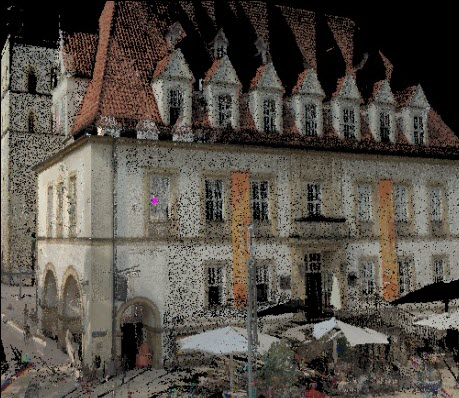
    <br>
    <figcaption>Figure 1. Visualization of point cloud dataset with RGB values <a href="#References">[3]</a>. The features apart from x, y, and z values, such as intensity and number of returns are quite valuable for the task of classification, but at the same time, they are sensor dependent and could become the main reasons for loss of generalization.</figcaption>
</figure>

## Point cloud classification

Point cloud classification is a task where each point in the point cloud is assigned a label, representing a real-world entity as described above. It is different from point cloud categorization where the complete point cloud dataset is given one label.

<figure>
        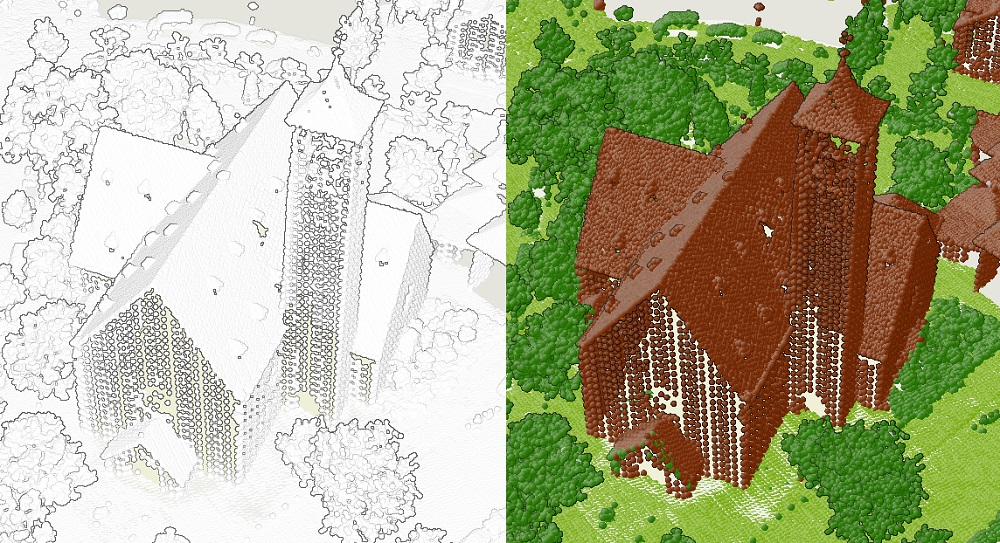
    <br>
    <figcaption>Figure 2. On the left side, raw LiDAR points can be seen. And for the same area, on the right side, we have classified points, where class codes are assigned to different colors <a href="#References">[2]</a>.</figcaption>

</figure>

Similar to how it's done with traditional convolutional neural networks, the point cloud classification process involves training – where the neural network learns from an already classified (labeled) point cloud dataset, where each point has a unique class code (see Figure 2. right image). These class codes are used to represent feature/s that we want the neural network to recognize. Note that one should not use a ‘thinned-out’ representation of a point cloud dataset that preserves only class codes of interest but drops a majority of the undesired return points, as we would like the neural network to learn and be able to differentiate points of interest class code and those that are not. Likewise, additional attributes that are present in training datasets, for example, Intensity, RGB, number of returns, etc. will improve the model’s accuracy but could inversely affect it if those parameters are not present in the datasets used for inferencing. As a result, it's recommended to use either a labeled portion of the data (on which we are planning to do the classification) or to use a more generalized training model built with the most common attributes (for example, a model trained to differentiate only with the help of x, y, and z values would be the most generic model to use).

When training a PointCNN model, the raw point cloud dataset is first converted into blocks of points containing a specific number of points. These blocks then get passed into the model for training along with their labels. A similar process is followed when using the model for predictions as well.

## X-Conv operation

As described in the Introduction section, a core part of the PointCNN framework is the X-Conv operation which is analogous to the convolution operation in CNNs. This operator performs a series of operations on a processed form of point cloud blocks, such as sampling and normalization using K-Nearest Neighbors. 

Let's illustrate this step with an example. The first step involves sampling several points, let's call it sample P from the input set of points N. Then, for the P number of points, we find K nearest neighbors from N points. This process is performed to form a local neighborhood of points for each point in P. This local neighborhood of points is then brought to a local coordinate space for each neighborhood. After these operations, we get an array of points of the shape (P, K, 3+E), where E is the number of extra features present (such as intensity, RGB values, or the number of returns), other than  x, y, and z.

<figure>
        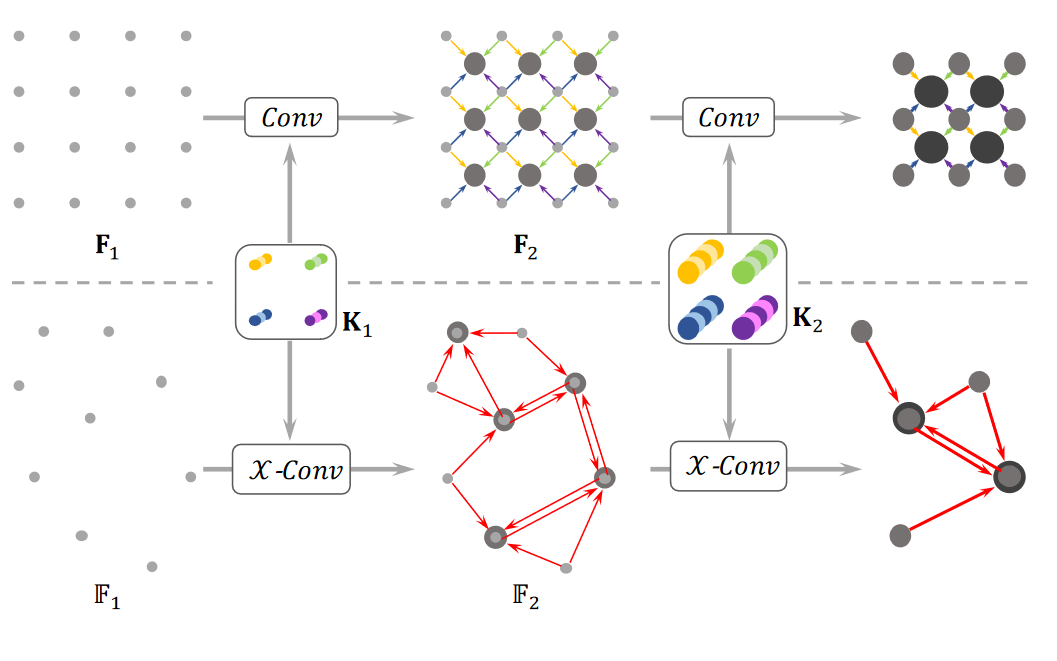
    <br>
    <figcaption>Figure 3. A diagram illustrating the difference and similarities of hierarchical convolution and PointCNN. The process above the dotted line denotes CNN in regular grids where convolutions are recursively applied on local grid patches. The process involves grid reductions – as done similarly in raster processing or meshing reducing the grid resolution successively (4X4⇥3X3⇥2X2), while increasing the channel number (visualized by dot thickness). Similarly, in point clouds, X-Conv is recursively applied to “project” or “aggregate” information, from the neighborhoods into fewer representative points (9⇥5⇥2) but each with richer information <a href="#References">[1]</a>.</figcaption>
</figure>

## PointCNN classification architecture

The PointCNN network for point cloud classification has a similar architecture to U-Net, as described in the <a href="https://developers.arcgis.com/python/guide/how-unet-works/" target="_blank">How U-net works</a> guide. Here too, we use an encoder-decoder paradigm, where the encoder reduces the number of points while increasing the number of channels. Then, the decoder part of the network increases the number of points, and the number of channels is incrementally reduced. The network also uses ‘skip connections’ like how it's done in the U-Net architecture. 

The difference is that the network processes a block of points as input and uses the X-Conv operation instead of Conv2D.

To state it succinctly, PointCNN differs from conventional grid-based CNNs primarily due to the application of X-Conv layers. Even then, the general process is like, how CNNs are used in grid-based convolution frameworks. The main differences are with respect to:

1. The way the local regions are extracted (K ⇥K patches vs. K neighboring points around representative points).
2. The way the information from local regions is learned (Conv vs. X-Conv) <a href="#References">[1]</a>.

<figure>
        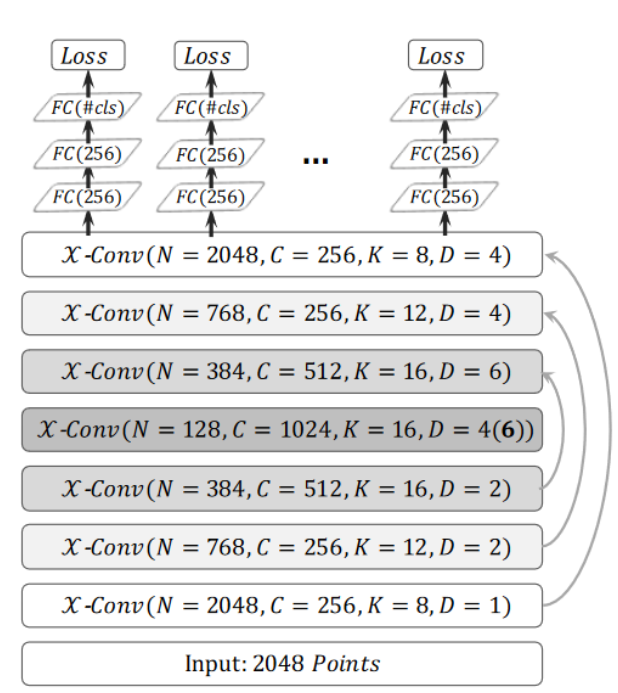
    <br>
    <figcaption>Figure 4. A Generalized representation of a PointCNN for classification architecture  <a href="#References">[1]</a>. In each X-Conv operation, N represents the number of points in the next layer, C represents the number of channels, K represents the number of nearest neighbors and D represents the dilation rate <a href="#References">[1]</a>.</figcaption>
</figure>

## Implementation in `arcgis.learn`

When training a PointCNN model using `arcgis.learn`, the raw point cloud dataset in LAS files is first converted into blocks of points, containing a specific number of points along with their class codes. 

For this step of exporting the data into an intermediate format, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards.

<p align="center">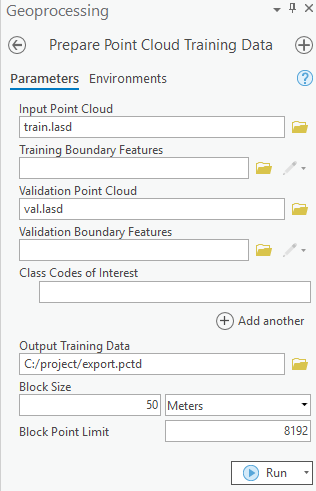</p>
<center>Figure 5. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/prepare-point-cloud-training-data.htm" target="_blank">Prepare Point Cloud Training Data</a> tool in ArcGIS Pro.</center>

These exported blocks are used to create a `data bunch` object that is passed into the `PointCNN` model for training.

```python
output_path=r'path/to/export.pctd'
data = prepare_data(output_path, dataset_type='PointCloud', batch_size=2)
pointcnn = PointCNN(data)
pointcnn.fit(20)
```
After training the PointCNN model, `compute_precision_recall()` method can be used to compute, per-class metrics (precision, recall, and f1-score) with respect to validation data. And `save()` method can be used to save the model.

For inferencing, use <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, available from ArcGIS Pro 2.8 onwards.

Main features available during the inferencing step:
       
- _Target classification:_ selective classification for flexibility and control in trained model's predictions.


- _Preserving specific classes in input data from modification:_ this can be used for updating old datasets and noise control in model's prediction.

<p align="center">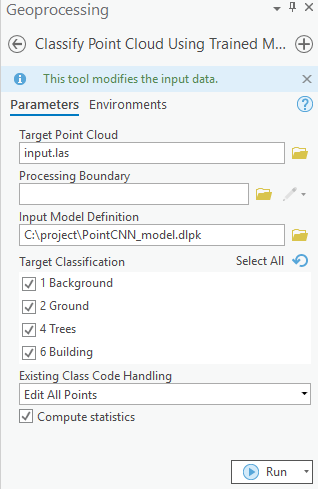</p>
<center>Figure 6. <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool. </center>

Detailed tool references and resources for point cloud classification using deep learning in ArcGIS Pro can be found <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">here</a>.

_**Note**:_ _API's_ `export_point_dataset()` _function and_ `predict_las()` _method, previously used for 'exporting' and 'inferencing' respectively, have been deprecated starting from 'ArcGIS API for Python' version 1.9.0._


### For advanced users 

We can also specify all the additional parameters while initializing PointCNN by using certain keyword arguments. One of those is `encoder_params` keyword argument, which can be used to specify the number of output channels for each layer in the encoder. The decoder of the network is built accordingly.

There are mainly four things that we need to define in the encoder: `out_channels`, `P`, `K`, and `D`. All of these are supplied as a 'python list'. The `out_channel` specifies the number of channels after each layer. While, for each layer `P`, `K` and `D` specify the 'number of points', 'k-nearest-neighbor', and 'dilation rate' respectively. Additionally, one can specify `m`, which is the multiplicative factor, that is multiplied by each element of the `out_channel` list. The other keyword arguments are `dropout` and `sample_point_num`. The `dropout` keyword argument specifies the amount of regularization we want to add to the model, with its value ranging between 0 and 1. The `sample_point_num` keyword argument specifies the number of points that will actually be used for training the model. It is usually equal to the number of maximum points in a block while exporting the point cloud dataset.

A typical usage looks like:

```python
pointcnn = PointCNN(data=data, 
                    encoder_params={'out_channels':[16, 32, 64, 96],
                                    'P':[-1, 768, 384, 128],
                                    'K':[12, 16, 16, 16],
                                    'D':[1, 1, 2, 2],
                                    'm':8
                                    },  
                    dropout=0.5,
                    sample_point_num=8192
                   )
```

## Setting up the environment

<i>Make sure to update your 'GPU driver' to a recent version and use 'Administrator Rights' for all the steps, written in this guide.</i>

_**Below, are the instructions to set up the required 'conda environment':**_

#### For ArcGIS Pro users:

<a href="https://github.com/esri/deep-learning-frameworks" target="_blank">Deep learning frameworks</a>
can be used to install all the required dependencies in  ArcGIS Pro's default python environment using an MSI installer. 

Alternatively,  
for a cloned environment of ArcGIS Pro's default environment, `deep-learning-essentials` metapackage can be used to install the required dependencies which can be done using the following command, in the _`Python Command Prompt`_ <i>(included with ArcGIS Pro)</i>:

`conda install -c esri deep-learning-essentials`

#### For Anaconda users (Windows and Linux platforms):

`arcgis_learn` metapackage can be used for both `windows` and `linux` installations of `Anaconda` in a new environment.

The following command will update `Anaconda` to the latest version. 

`conda update conda`

After that, metapackage can be installed using the command below:

`conda install -c esri arcgis_learn python=3.7`

_(Alternatively, 3.6 and 3.8 versions of `python` are also supported with the metapackage.)_

## Best practices for PointCNN workflow

The following tips and best-practices can be used while using PointCNN:

- The <a href="https://pro.arcgis.com/en/pro-app/latest/help/data/las-dataset/introduction-to-deep-learning-and-point-clouds.htm" target="_blank">3D deep learning tools</a> in the <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/an-overview-of-the-3d-analyst-toolbox.htm" target="_blank">3D Analyst extension</a>, takes care of the coordinate system, and related discrepancies, automatically. So, one can train a model using ArcGIS Pro on a dataset with a metric coordinate system, then use that trained model on a dataset with any other coordinate system, and vice-versa without any need of re-projection.

- High quality labeled data will result in a better-trained model. For generalization and robustness of the trained PointCNN model, significant diversity or variety should be present in the training data, in terms of geography, architectures, terrains, object-related variations, etc.

- If the object of interest is significantly larger or smaller in size than the default value of `block_size`, then a better value can be used for improving the results further. Like, for a dataset in a metric coordinate system, a _'warehouse'_ won't fit in a '50 meter' x '50 meter' `block_size`, hence the `block_size` can be increased in this case. 

- Through a series of experiments, it was found that an additional one or two `extra_features` apart from X, Y, and Z usually works best, in most cases. Over usage of 'extra attributes' for model training might reduce _'how generic the trained model will be'_. 

- Deciding which 'extra attributes' to consider, depends upon the properties of the object of interest, nature of noise, sensor-specific attributes, etc. 

- It is recommended to filter/withheld points that belong to 'high noise' class from the dataset.

- If the training and validation dataset is very large and each epoch is taking a lot of time to complete, then `iters_per_epoch` can be used to see the epoch/training table quickly by reducing the time taken for the completion of an epoch. This is achieved by a random selection/filtering of fewer batches, governed by the user-provided value of `iters_per_epoch`. So in each epoch the model is exposed to a lesser number of randomly selected batches, this results in faster completion of an epoch, but it can lead to more numbers of epochs before the model converges. 

- `mask_class` functionality in `show_results()` can be used for analyzing any inter-class noises present in the validation output. This can be used to understand which classes need more diversity in training data or need an increase in its number of labeled points _(As shown in Figure 5)_.


<p align="center"><img src="../../static/img/pointcnn_guide_gif_1.gif" /></p>

<center>Figure 7. Class-based masking of points, to understand the nature of noise in the prediction.</center>

- The default value of `max_display_point` is set to '20000', keeping the rendering-related browser limitation in mind, which can occur for very dense point clouds. This value can be increased if needed, for detailed visualization, within the browser itself. 

- `Target classification` and `class preservation` in <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool, can be used in conjunction to combine the knowledge of multiple trained models for a single scene. 

- Features like, `classes_of_interest` and `min_points` are especially useful when training a model for SfM or mobile/terrestrial point clouds. In specific scenarios when the 'training data' is not small, these features can be very useful in speeding up the 'training time', improving the convergence during training, and addressing the class imbalance up to some extent.

- Fine-tuning a pre-trained model is only preferred if the 'object of interest' is either same or similar, else it is not beneficial. Otherwise, fine-tuning a pre-trained model can save cost, time, and compute resources while providing better accuracy/quality in results.

- Class codes can be given a meaningful name, using `class_mapping`. The names of the class codes are saved inside the model, which are automatically retrived by <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/classify-point-cloud-using-trained-model.htm" target="_blank">Classify Points Using Trained Model</a> tool and <a href="https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/train-point-cloud-classification-model.htm" target="_blank">Train Point Cloud Classification Model</a> tool, when a trained model is loaded.






- For fine-tuning a PointCNN model with default architecture settings;  'class structure', 'extra attributes', and `max_points` should match between the pre-trained model and the exported 'training data'.

## References


[1] Li, Y., Bu, R., Sun, M., Wu, W., Di, X., & Chen, B. (2018). PointCNN: Convolution On $\mathcal{X}$-Transformed Points. Advances in Neural Information Processing Systems, 2018-Decem, 820–830. http://arxiv.org/abs/1801.07791


[2] Dmitry Kudinov. (2019). PointCNN: replacing 50,000 man hours with AI.   
https://medium.com/geoai/pointcnn-replacing-50-000-man-hours-with-ai-d7397c1e7ffe


[3] AutoDesk. (2020). About Point Cloud Color Stylization and Visual Effects.  
https://knowledge.autodesk.com/support/autocad/learn-explore/caas/CloudHelp/cloudhelp/2020/ENU/AutoCAD-Core/files/GUID-75EBFA48-CB7E-4E91-A1BB-167D96A7119F-htm/